In [1]:
# !/usr/bin/env python
# coding: utf-8

# ---- Library import ----

import pickle
from time import gmtime, strftime

import albumentations
import math
import torch.nn as nn
from torch.utils.data import DataLoader
import torchy

# ---- My utils ----
from utils.train_arguments import *
from utils.utils_data import *
from utils.utils_training import *

# Primero necesitamos reescalar (si usamos los coeficientes de Efficientnet) la resolucion de las imagenes a usar
args.crop_size = math.ceil(args.crop_size * args.resolution_coefficient)
args.img_size = math.ceil(args.img_size * args.resolution_coefficient)

train_aug = albumentations.Compose([
    albumentations.PadIfNeeded(p=1, min_height=args.crop_size, min_width=args.crop_size),
    albumentations.Resize(args.img_size, args.img_size),
    albumentations.RandomCrop(p=1, height=args.crop_size, width=args.crop_size)
])

val_aug = albumentations.Compose([
    albumentations.PadIfNeeded(p=1, min_height=args.crop_size, min_width=args.crop_size),
    albumentations.Resize(args.img_size, args.img_size),
    albumentations.CenterCrop(p=1, height=args.crop_size, width=args.crop_size)
])

if args.data_augmentation:
    print("Data Augmentation to be implemented...")

train_dataset = ISIC2019_FromFolders(data_partition="train", albumentation=train_aug)

usage: ipykernel_launcher.py [-h] [--verbose] [--weighted_loss]
                             [--pretrained_imagenet] [--epochs EPOCHS]
                             [--batch_size BATCH_SIZE] [--cutmix] [--retinex]
                             [--shade_of_gray] [--colornet]
                             [--model_name MODEL_NAME]
                             [--optimizer {adam,sgd,rmsprop}]
                             [--freezed_epochs FREEZED_EPOCHS]
                             [--snapshot SNAPSHOT] [--balanced_sampler]
                             [--depth_coefficient DEPTH_COEFFICIENT]
                             [--width_coefficient WIDTH_COEFFICIENT]
                             [--resolution_coefficient RESOLUTION_COEFFICIENT]
                             [--compound_coefficient COMPOUND_COEFFICIENT]
                             [--learning_rate LEARNING_RATE]
                             [--data_augmentation] [--img_size IMG_SIZE]
                             [--crop_size CROP_SI

Working with Jupyter notebook! (Default Arguments)
results/new_logs_efficientnet_adam/


In [2]:
TRAIN_FILE = ISIC_PATH + "train.txt"
TRAIN_IMGS = open(TRAIN_FILE).read().split('\n')

In [3]:
len(TRAIN_IMGS)

21532

In [4]:
for indx, img in enumerate(TRAIN_IMGS):
    # Corregimos el path para que sea absoluto
    if '.jpg' in img:
        TRAIN_IMGS[indx] = ISIC_PATH + "Train/" + "/".join(img.split("/")[1:])
TRAIN_IMGS = list(filter(None, TRAIN_IMGS)) # Sanity check no empty lines/items in list

In [5]:
len(ISIC_TRAIN_DF_TRUTH)

25331

In [6]:
ISIC_TRAIN_DF_TRUTH.head()

,Unnamed: 0,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,target
0,0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
np.unique(ISIC_TRAIN_DF_TRUTH.target)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [17]:
target_0 = len(ISIC_TRAIN_DF_TRUTH.loc[ISIC_TRAIN_DF_TRUTH['target'] == 0])
target_1 = len(ISIC_TRAIN_DF_TRUTH.loc[ISIC_TRAIN_DF_TRUTH['target'] == 1])
target_2 = len(ISIC_TRAIN_DF_TRUTH.loc[ISIC_TRAIN_DF_TRUTH['target'] == 2])
target_3 = len(ISIC_TRAIN_DF_TRUTH.loc[ISIC_TRAIN_DF_TRUTH['target'] == 3])
target_4 = len(ISIC_TRAIN_DF_TRUTH.loc[ISIC_TRAIN_DF_TRUTH['target'] == 4])
target_5 = len(ISIC_TRAIN_DF_TRUTH.loc[ISIC_TRAIN_DF_TRUTH['target'] == 5])
target_6 = len(ISIC_TRAIN_DF_TRUTH.loc[ISIC_TRAIN_DF_TRUTH['target'] == 6])
target_7 = len(ISIC_TRAIN_DF_TRUTH.loc[ISIC_TRAIN_DF_TRUTH['target'] == 7])

<BarContainer object of 8 artists>

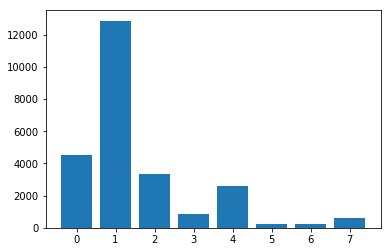

In [18]:
plt.bar(np.arange(0,8),[target_0,target_1,target_2,target_3,target_4,target_5,target_6, target_7])

In [19]:
total_targets = target_0+target_1+target_2+target_3+target_4+target_5+target_6+target_7

In [20]:
1/(target_0/total_targets)

5.60172490048651

In [21]:
weights = [1-(target_0/total_targets), 1-(target_1/total_targets), 1-(target_2/total_targets),
1-(target_3/total_targets), 1-(target_4/total_targets), 1-(target_5/total_targets), 
1-(target_6/total_targets), 1-(target_7/total_targets)]

In [22]:
weights

[0.8214835576961036,
 0.4917295014014449,
 0.8688168647112234,
 0.965773163317674,
 0.8964115115865935,
 0.9905649204531997,
 0.9900122379692866,
 0.9752082428644744]

<BarContainer object of 8 artists>

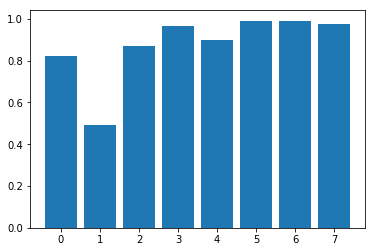

In [23]:
plt.bar(np.arange(0,8),weights)

In [24]:
class_weights = torch.FloatTensor(weights).cuda()

In [25]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [26]:
with open("class_weights_subtract.pkl", "wb") as fp:   #Pickling
    pickle.dump(weights, fp)

In [27]:
weights = [1/(target_0/total_targets), 1/(target_1/total_targets), 1/(target_2/total_targets),
1/(target_3/total_targets), 1/(target_4/total_targets), 1/(target_5/total_targets), 
1/(target_6/total_targets), 1/(target_7/total_targets)]

In [28]:
weights

[5.60172490048651,
 1.9674563106796117,
 7.62293108636774,
 29.21683967704729,
 9.653582317073171,
 105.98744769874477,
 100.12252964426878,
 40.3359872611465]

<BarContainer object of 8 artists>

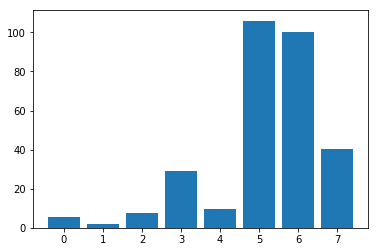

In [29]:
plt.bar(np.arange(0,8),weights)

In [30]:
class_weights = torch.FloatTensor(weights).cuda()

In [31]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [32]:
with open("class_weights_divide.pkl", "wb") as fp:   #Pickling
    pickle.dump(weights, fp)